# Gridding and Filtering of Elevation Change Observations   

In this tutorial we will discuss different types of gridding and filtering strategies that are commonly used in satellite altimetry to derive gridded products of elevation change. We will then use these gridded products to derive integrated volume change of the region in question.

## Background

In many aspects of Earth Science gridded datasets plays an important role for understanding and extracting geophysical signals in both space and time. 

So, what might be the reasons of why we want to use gridded data?

- Estimation of geophysical signals in un-observed regions, based on noisy observations.
- Data-reduction, where billions of points can be represented as a regular-grid.
- Application of advanced digital signal processing algorithms.
- Data visualization

Satellite altimetry has for decades been used to study the worlds ice sheets and glaciers by measuring the change of elevation over time. One of the most widely used methods for deriving elevation change from altimetry is the "crossover" method. It is one of the most robust and accurate methods currently available. It can be used for both deriving elevation change and to study the precision of the measurements themselves.

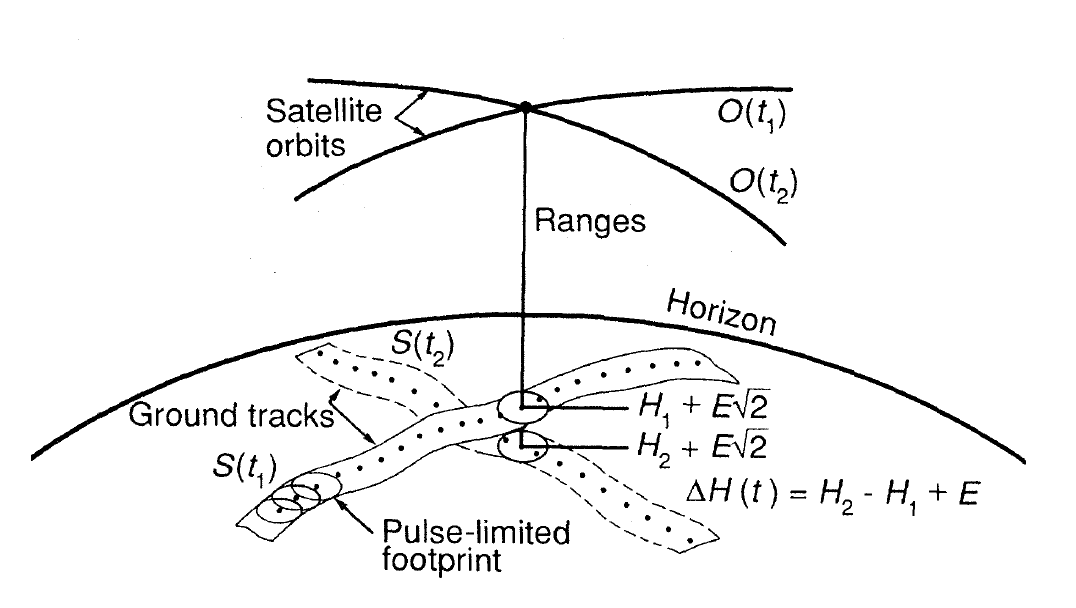   

From this method the surface elevation change is estimated at the intersection of two sub-satellite ground tracks at different times. At this crossover location the two closest points in each track is used to interpolate both elevation and time to the crossover location, allowing us to compute $\delta h/\delta t$ = $H_{t_{2}}-H_{t_{1}}$. [Image credit Zwally et al. (1989)]

## Elevation Change Case Study: Pine Island Glacier

In this section we will use crossover elevation changes from ICESat and ICESat-2 spanning the time span of 2003-2019 (16 years) over Pine Island Glacier (PIG) in West Antarctica. PIG is one of the most active areas in Antartcica showing the largest rates of elevation change on the continent.

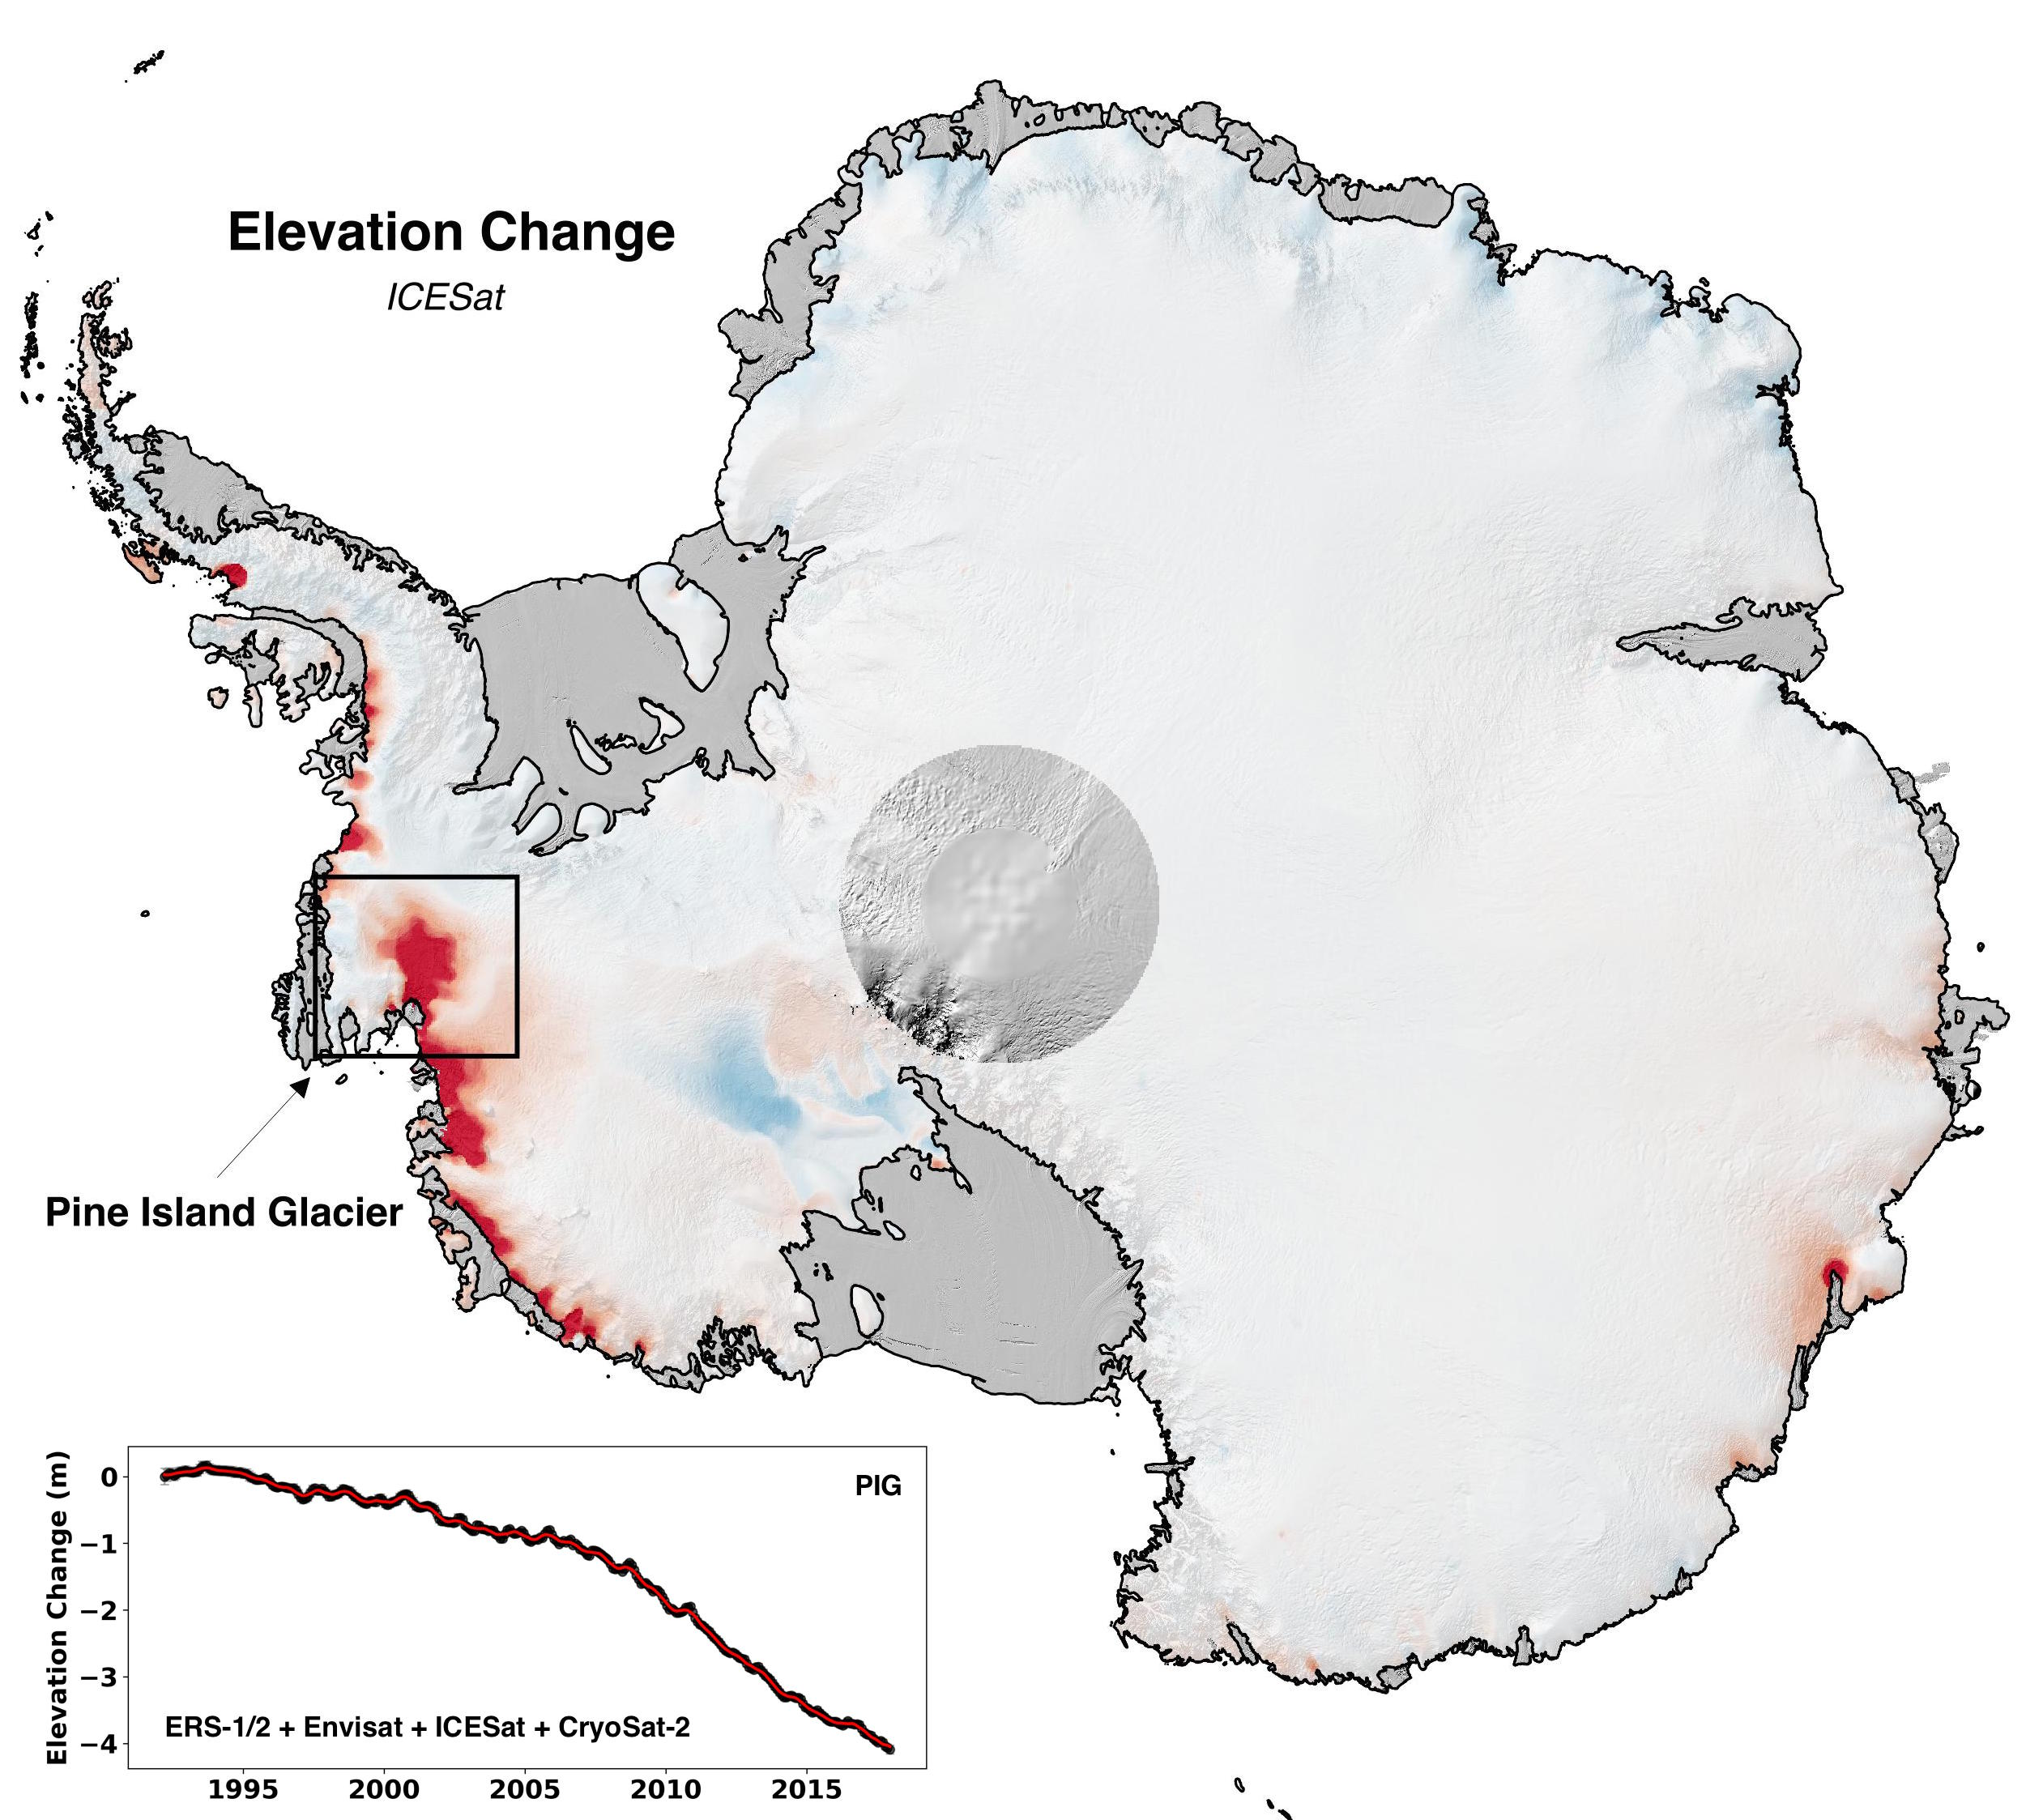

Before, we start with the excersice we need to import some packages and functions needed for the analysis. Many of them can be found in the "utils.py" file and have been written and devloped here at JPL as part of the captoolbox, which will soon be avaliable.[ Image credit: Johan Nilsson (JPL) ]

In [1]:
%matplotlib inline
import h5py
import numpy as np
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from utils import gaussip
from utils import medip
from utils import lscip
from utils import transform_coord
from utils import make_grid
from utils import mad_std
from utils import spatial_filter
from utils import interp2d
from scipy.ndimage.filters import generic_filter

Before we do anything we need to get our data into our local enviroment in our little jupyter world! Let's mow download it from the ICESat-2 Hackweek S3 bucket by running the code below (just once):

In [ ]:
!aws --no-sign-request s3 sync s3://pangeo-data-upload-oregon/icesat2/gridding-data/ data/

Let's load the crossovers so we can start working, using the h5py library. But first let's inspect what varibales we have to work with.

In [2]:
!h5ls ./data/IS1_IS2_AnIS_XOVER_PIG_ALL_BEAMS_R205.h5

dh_elv                   Dataset {40992}
dhdt                     Dataset {40992}
dt_year                  Dataset {40992}
h_elv_1                  Dataset {40992}
h_elv_2                  Dataset {40992}
lat                      Dataset {40992}
lon                      Dataset {40992}
t_year_1                 Dataset {40992}
t_year_2                 Dataset {40992}


For this tutorial we are going to use the longitude (lon), latitude (lat) and the elevation change (dhdt) variables. The "dhdt" variable can be created by dividing "dh_elv" with "dt_year". 

Let's load the data into memory!

In [3]:
with h5py.File('./data/IS1_IS2_AnIS_XOVER_PIG_ALL_BEAMS_R205.h5','r') as f_in:

    lat  = f_in['lat'][:]
    lon  = f_in['lon'][:]
    dhdt = f_in['dhdt'][:]

Now, let's plot the data to get an understanding of the spatial coverage and signals! We are going to use cartopy for this!

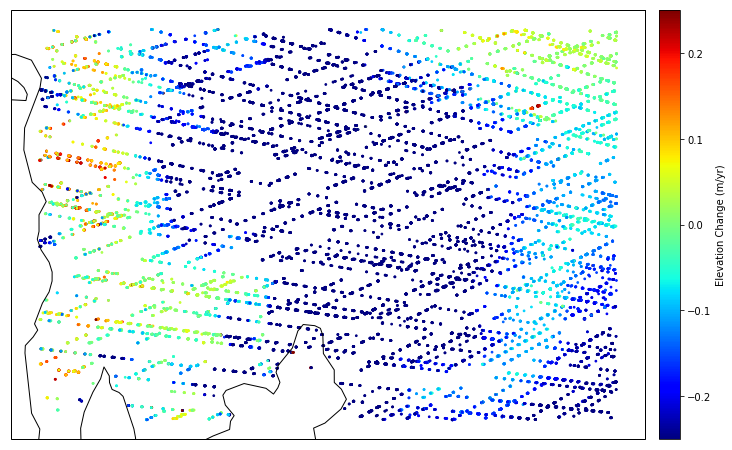

In [4]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
plt.scatter(lon[::1], lat[::1], s=3,c=dhdt[::1], alpha=1.0, \
            transform=ccrs.Geodetic(),cmap='jet')
plt.clim([-0.25,0.25])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation Change (m/yr)')
ax.coastlines('50m')

From this map we can see that we are actually dealing with realtively dense point data! We, can clearly see the drawdown in the main trunk of the Pine Island Glacier. However, we still have large uncovered areas with no observations and noisy data. This means that if we want to compute the volume loss of this region we need to perform some interpoaltion and filtering.   

Let's start preparing the data for the interpolation algorithms!

## Filtering of elevation change observations
In this section we will quickly go trough a few common ways of filtering and editing elevation change datasets to remove outliers. This is an important step as any remaning outliers will produce artifacts in the final gridded product and make the results difficult to interperet. Now, let's determine how much noise we have in our current $\delta h/\delta t$ distribution.

### Histogram analysis and the $\sigma$-editing rule

A common statistical framework to analyze and edit data is by analysing the distribution using the histogram, and to remove data of poor quality using eiether a statistical based threshold, or a threshold based on visual inspection.

Let's now plot the histogram of the un-filtered elevation change data!

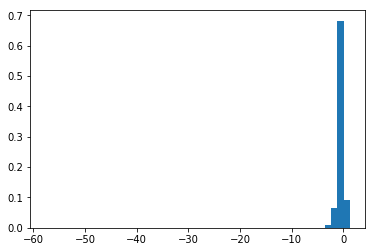

In [5]:
a = plt.hist(dhdt, 50, density=True)

We can see that the histogram has a large range of values between -60 and 10 m/yr. These values are unrealistic as you would not expect rates this large. So, for now let's use only values between -5 and 5 m/yr to get an idea about the distribution.

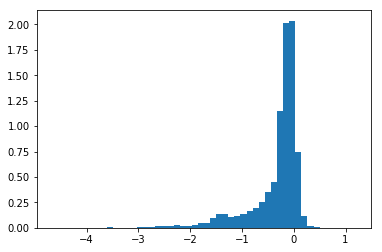

In [6]:
fig = plt.hist(dhdt[np.abs(dhdt) < 5], 50, density=True)

Using the $\pm$ 5 m/yr threshold we can easily see that most of our values are within this range. Further, we can also see that we have a negativly skewed distribution! The negative skewness corresponds the main drawdown in the trunk of PIG, seen in the previous map. 

Using the visually determined value of $\pm$ 5 m/yr, we reject anything with a magnitude larger than this value and compute some statistics. 

In [7]:
print('Mean:', np.around(100*np.nanmean(dhdt[np.abs(dhdt) < 5]),3), 'cm/yr')
print('Std.dev:',np.around(100*np.nanstd(dhdt[np.abs(dhdt) < 5]),3), 'cm/yr')
print('Rejected:', np.around(100*(float(len(dhdt[np.abs(dhdt) > 5]))/len(dhdt)),3), '%')

('Mean:', -33.925, 'cm/yr')
('Std.dev:', 51.175, 'cm/yr')
('Rejected:', 0.005, '%')


We can that using the $\pm$ 5 m/yr threshold no data was rejected.

Another way to edit the data is to use the sigma-rule, where we statisticaly determine the threshold. Most commonly used is the $3\sigma$-rule (99.7%).

In [8]:
# Only select good points 
i_o = np.abs(dhdt-np.nanmean(dhdt)) < 3 * np.nanstd(dhdt)

We now only keep the observations that full-fills this criterion, i.e onlye keep observations inside $3\sigma$ interval. 

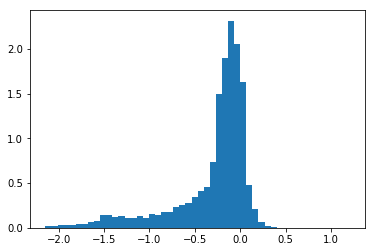

In [9]:
fig = plt.hist(dhdt[i_o], 50, density=True)

This roughly gives us the same range of values as from the visual inspection!

In [10]:
print('Mean:', np.around(100*np.nanmean(dhdt[i_o]),3), 'cm/yr')
print('Std.dev:',np.around(100*np.nanstd(dhdt[i_o]),3), 'cm/yr')
print('Rejected:', np.around(100*(float(len(dhdt[~i_o]))/len(dhdt)),3), '%')

('Mean:', -30.449, 'cm/yr')
('Std.dev:', 42.803, 'cm/yr')
('Rejected:', 1.52, '%')


Here, we can see that we rejected around 10% of the data, lowering the standard deviation, but keept the mean roughly the same. The power of this technique is that it allows for editing based only on the statistics of the data avoiding visual inspection, which can be difficult for large datasets.

### Spatial outlier editing of elevation change observation 
Previously, we used the histogram and $\sigma$-rule editing approach to remove outliers. However, this approach is spatially invariant. It does not take into account the spatial distirbution of the data, introducing a risk that we remove signals that are important to the overall mass balance. These signals are mostly located in the marginal areas, as can be seen in our figure, of the ice sheet where the largest magnitude of change can be observed. 

So, instead of editing on the regional or continental distribution we can separated the observations into induvidual spatial block of a given dimension. Provided these blocks we then apply the same $\sigma$ editing approach to the data inside each induvidual block.

Before, we filter the data we converte our coordinates into South-Polar Stereographic projection (EPSG:3031). This allows us to compute distances easier and also to reduce the number of grid-cells we need to process compared to using geographical coordinates. The transformation can very convenently done using the "pyproj" (https://pypi.org/project/pyproj/) package. 

Let's converte from geograohical coordinates (EPSG 4326) into South-Polar stereographic (EPSG 3031) using pyproj!

In [11]:
x, y = transform_coord('4326','3031', lon, lat)

Now let's filter the data using the spatial outlier editing approach, observations flagged as outliers are replaced by a NaN-value. 
Let's divide the crossover data into 20 km spatial bins and edit using 3$\sigma$

In [12]:
# Run spatial filter with 20 x 20 km regions and reject data larger than 3-sigma
z = spatial_filter(x, y, dhdt, dx=20e3, dy=20e3, sigma=3)

print('Mean:', np.around(100*np.nanmean(z),3), 'cm/yr')
print('Std.dev:',np.around(100*np.nanstd(z),3), 'cm/yr')
print('Rejected:', np.around(100*(float(len(z[np.isnan(z)]))/len(z)),2), '%')

('Mean:', -34.038, 'cm/yr')
('Std.dev:', 51.02, 'cm/yr')
('Rejected:', 0.76, '%')


/Users/nilssonj/anaconda2/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


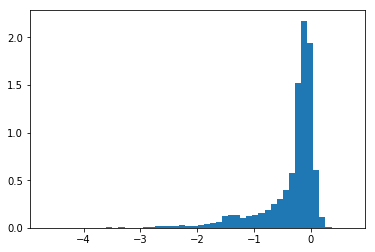

In [13]:
fig = plt.hist(z[~np.isnan(z)], 50, density=True)

Data is now filtered! Notice we rejected less data but preserved more signal, which can seen in the range of the histogram.

## Spatial Interpolation of scattered data

Once, the data has been filtered we can interpolate the points data to a regular grid to allow for different kinds of analysis and mass-balance computations.
Here, we will present three types of different interpolation schemes and discuss pro's and cons of each approach

Interpolation algorithms:
* Median
* Gaussian Weighted Average
* Least-Squares Collocation (Kriging)

Now let's construct a 5x5 km regular grid that we will use for the for the interpolation!

In [14]:
Xi, Yi = make_grid(x.min(), x.max(), y.min(), y.max(), dx=5e3, dy=5e3)

In [15]:
# Transform grid to Lat/Lon for plotting
Lon, Lat = transform_coord('3031', '4326', Xi, Yi)

We, further need to mask the data so we only get values over the grounded ice sheet! Let's load a mask to take care of that!

In [16]:
with h5py.File('./data/ANT_groundedice_1000m.h5','r') as f_mask:

    Xm = f_mask['X'][:]
    Ym = f_mask['Y'][:]
    Zm = f_mask['Z'][:]

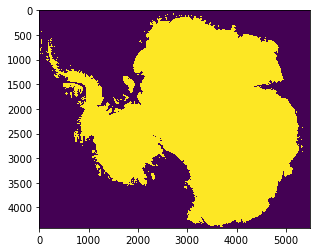

In [17]:
plt.imshow(Zm)

Now interpolate and cut the mask to our region only

In [18]:
# Bilinear interpolation from grid to point, if nearest use order=0
Zm_ip = interp2d(Xm, Ym, Zm, Xi.ravel(), Yi.ravel(), order=1).reshape(Xi.shape)

Let's check the mask to see if it worked?

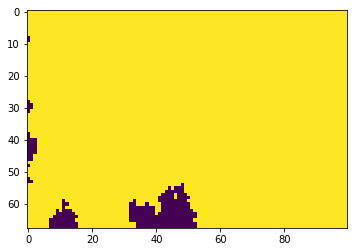

In [19]:
plt.imshow(np.flipud(Zm_ip))

### Interpolation using the Median
Using the median for spatial interpolation has some advantages, as it is less sensitive to outliers in the data, and thus provide very clean and nice looking grids. However, for producing volume change estimates for large regions (continetal) it is less useful. This is because, as we could see in the histogram, we usually have a negative skewed distributions of elevation change. Thus, using the median we will estimates value will be biast in the positive direction. Further, the usage of the median does not allow us to incorporate far-field data, as no weighting for distance is possible. 

The median value is computed for eac grid cell using the n-closest values in space:

\begin{equation*}
z_{pred} = median(z_{i})
\end{equation*}

Let's grid and plot the data using the n = 100 closest points and a cut-off distance of 100 km. 

In [20]:
z_med = medip(x, y, z, Xi, Yi, n=100, d=100e3)

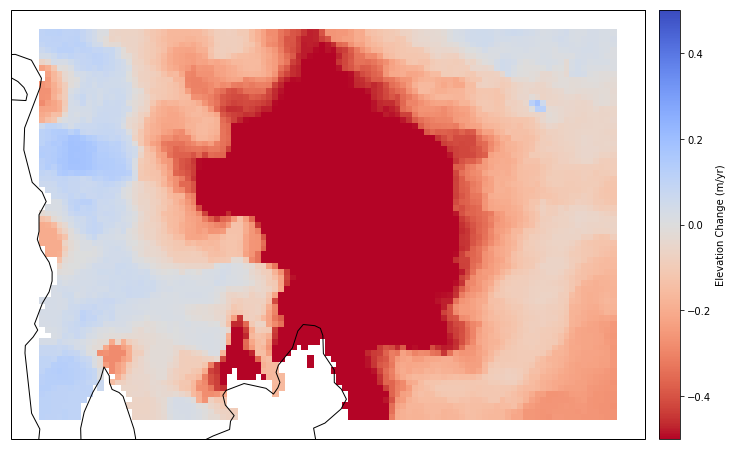

In [25]:
# Reshape from vector to array
Z_med = z_med.reshape(Xi.shape)

# Apply the masks to the grid
Z_med[Zm_ip == 0] = np.nan

fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
plt.pcolormesh(Lon,Lat,Z_med,cmap='coolwarm_r',transform=ccrs.PlateCarree())
plt.clim([-0.5,0.5])
plt.colorbar(fraction=0.032, pad=0.02, label='Elevation Change (m/yr)')
ax.coastlines('50m')

### Interpolation using Gaussian Weighed Average
One of the most common interpolation approaches to interpolate irregular scattered data onto a regular grid using a weighted average, with a gaussian weighing function based on distance away from the prediction point. This interpolation approach provides a smooth continious surface constraind by the range of the data. However, the weighted average is sensitiv to large outliers and the data distribution, the same as for the median.

The weighting fucntion can be written as follows:

\begin{equation*}
w_{i} = \frac{1}{\sigma^{2}} \exp \Bigg(-\frac{r^{2}}{\alpha^{2}}\Bigg)
\end{equation*}

where $\alpha$ is the correlation length, $r$ is the spatial distance and $\sigma$ the error of each observation. The predicted value is then estimated by taking the weighted avarage of selected observations, according to:

\begin{equation*}
z_{pred} = \frac{\sum{w_{i} z_{i}}}{\sum w_{i}}
\end{equation*}

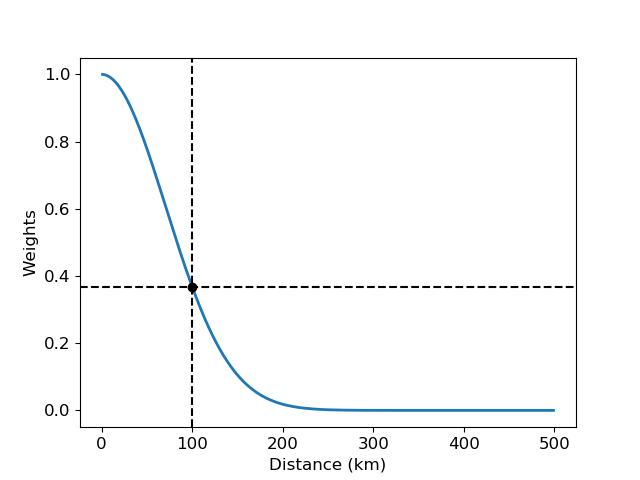

We should note here that this interpolation technique introduces blurring in the derived spatial field. Hence, reducing the amount of details that can be observed. The blurring, or smoothenss, can be controlled by the correlation length parameter. Where a smaller length preserves more detail and a larger value increases the blurring or smoothness. 

Now let's grid the data using the same parameters as for the median interpolation, using a 25 km correlation length.

In [22]:
z_gauss = gaussip(x, y, z, np.ones(x.shape), Xi, Yi, n=100, d=100e3, a=25e3)

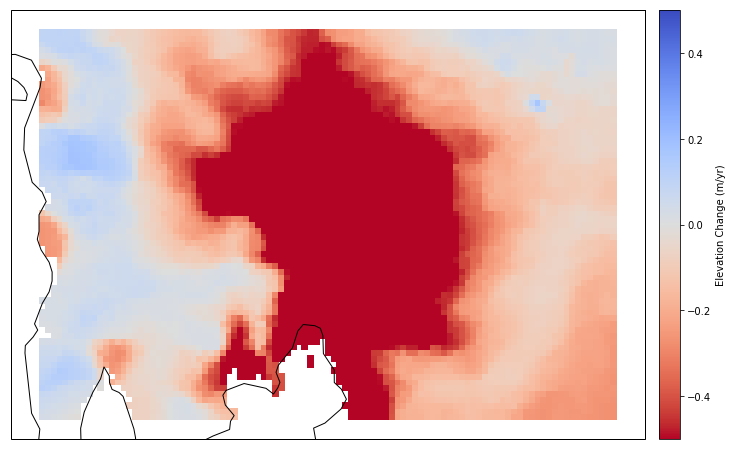

In [24]:
# Reshape from vector to array
Z_gauss = z_gauss.reshape(Xi.shape)

# Apply the masks to the grid
Z_gauss[Zm_ip == 0] = np.nan

fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
plt.pcolormesh(Lon,Lat,Z_gauss,cmap='coolwarm_r',transform=ccrs.PlateCarree())
plt.clim([-0.5,0.5])
plt.colorbar(fraction=0.032, pad=0.02, label='Elevation Change (m/yr)')
ax.coastlines('50m')

### Interpolation using Least-Squares Collocation (Ordinary Kriging)

Least-Squares Collocation (LSC), mostly known as Kriging, is a geostatistical method of spatial interpolation modeled by a gaussian process governed by the data covariance. In genreal the LSC method is better at preserving spatial detail and variability than other simpler distance-based interpolation methods, if the spatial auto-correlation of the data is substantial. LSC, also generates estimates of uncertainty for each prediction and also allows for error-propagation via the covariance structure.

We can write the prediction formula as follows:

\begin{equation*}
z_{pred} = C_{xy} (C_{xx} - N)^{-1} z_{i} + \big(1-\sum(C_{xy} (C_{xx} - N)^{-1}\big) m(z_{i})
\end{equation*}

where $C_{xy}$ is the cross-correlation $C_{xx}$ the auto-correlation, $N$ an addative diagonal noise term for each observation and $m(z)$ the median value of the local observations. The covariance is modeled in this case by a 2$^{nd}$ order Markov model based on the distance of the data from the prediciton point to each observation.

\begin{equation*}
C(r) = C_{0} \Big(1 + \frac{r}{\alpha}\Big) e^{-r/\alpha}
\end{equation*}

where $C_{0}$ is the data variance, $r$ the distance between the prediction point and the observations and $\alpha$ is determined from the correlation length of the data. Finally, we can compute an estimate of the uncertainty for the prediction point using the following formula.

\begin{equation*}
\sigma^{2}_{pred} = C_{0} - C_{xy} (C_{xx} - N)^{-1} C_{xy}^{T}
\end{equation*}

where $C_{xy}^{T}$ is the transposed matrix.

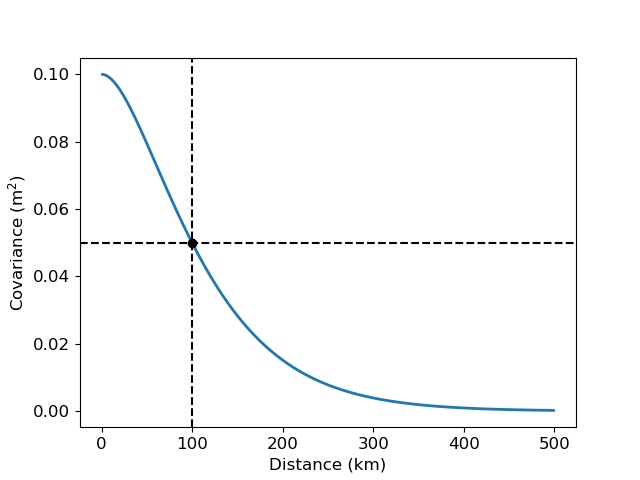

One of the major disadvantages of this method is that it more computational expensive than the other methods, as it requires the solution, or inversion, of the covariance matrix $(C_{xx} - N)^{-1}$. Which scales with the number of observations used for the prediction. 

Now let's use, like the other interpolation algorithms, the 100 closest points for each solution, a cut-off radius of 100 km and a correlation length of 25 km.

In [26]:
# Function does not like NaN's, so lets remove them
xp, yp, zp = x[~np.isnan(z)], y[~np.isnan(z)], z[~np.isnan(z)]

In [27]:
# Run kriging interpolator, with 1 m RMSE noise added to the diagonal (np.ones(xp.shape)*1)
z_lsc, e_lsc = lscip(xp, yp, zp, np.ones(xp.shape)*1, Xi, Yi, n=100, d=100e3, a=25e3)[0:2]

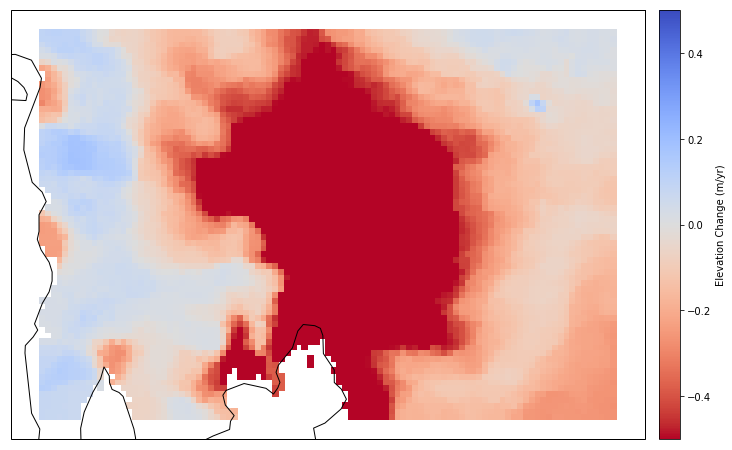

In [28]:
# Reshape from vector to array
Z_lsc = z_lsc.reshape(Xi.shape)

# Apply the masks to the grid
Z_lsc[Zm_ip == 0] = np.nan

fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
plt.pcolormesh(Lon,Lat,Z_lsc,cmap='coolwarm_r',transform=ccrs.PlateCarree())
plt.clim([-0.50,0.50])
plt.colorbar(fraction=0.032, pad=0.02, label='Elevation Change (m/yr)')
ax.coastlines('50m')

Now let's also plot the estimated prediction error from the interpolation.

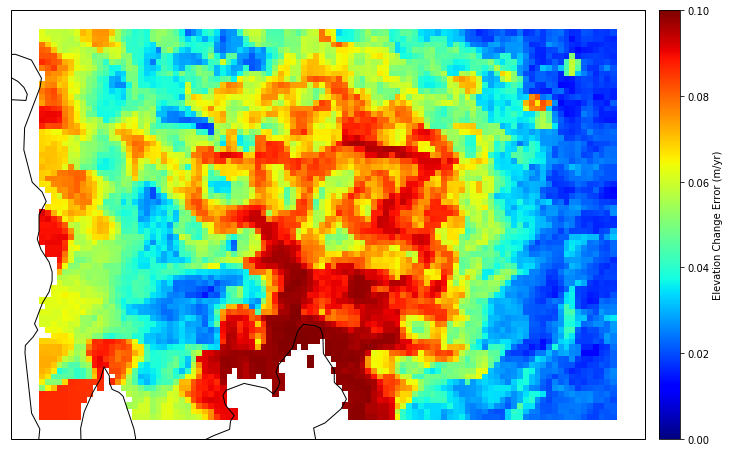

In [29]:
# Reshape from vector to array
E_lsc = e_lsc.reshape(Xi.shape)

# Apply the masks to the grid
E_lsc[Zm_ip == 0] = np.nan

fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
plt.pcolormesh(Lon,Lat,E_lsc,cmap='jet',transform=ccrs.PlateCarree())
plt.clim([0,0.1])
plt.colorbar(fraction=0.032, pad=0.02, label='Elevation Change Error (m/yr)')
ax.coastlines('50m')

Here, we can observe that the derived error, or RMSE, of the LSC\Kriging method is largest by the terminus of PIG. This is to be expected as its here where we have the largest magnitude of variability in the data, which gets propagated into the overall error estimate.

### Estimating Volume Change from Gridded Data

Once the data has been gridded we can start computing and estimate the volume change of the region in question. This can be done by integrating our estimates values over the desired region, according to:

\begin{equation*}
\frac{dV}{dt} = \int_{Area}^{}\frac{dh}{dt} dA 
\end{equation*}

Well this seem extremly mathematical and difficult! Lucky for us is that we now have a discrete grid, so the integral reduces down to a sum instead!

\begin{equation*}
\frac{dV}{dt} = \sum_{i=0}^{N}\Big(\Big[\frac{dh}{dt}\Big]_{i} \Delta A \Big)
\end{equation*}

where $\Delta A = \Delta x \cdot \Delta y$ is the grid-spacing in each dimension, which currently is 5 km.

Let's compute the volume change estimate for the region from the three methods!

In [30]:
print('Volume Change MED:', np.around(np.nansum(Z_med) * 5e3 * 5e3 * 1e-9,3), 'km3/yr')
print('Volume Change AVG:', np.around(np.nansum(Z_gauss) * 5e3 * 5e3 * 1e-9,3), 'km3/yr')
print('Volume Change LSC:', np.around(np.nansum(Z_lsc) * 5e3 * 5e3 * 1e-9,3), 'km3/yr')

('Volume Change MED:', -60.116, 'km3/yr')
('Volume Change AVG:', -60.655, 'km3/yr')
('Volume Change LSC:', -60.811, 'km3/yr')


We can see that for this region all three methods produce similar results, indicating good spatial coverage and data density. One should expect larger differences on a continetal scale between the median and the other two methods due to the previously discussed statistical nature of the median method (biases to less negative rates).

## Spatial Filtering using Kernels

Ok, now we have filtered the data from outliers and converted the point data into a gridded spatial field, but even with all the outlier rejection and smoothing provided by the interpoaltion we still might have artifacts and noise in our derived grid. How do we handle this and what do we use?

Well the field of image processing have provided us with plenty of tools we can apply to our gridded data! One of the most commonly used are spatial filters applying mathematical operations using kernels! So, what is a kernel, or also called a convolution matrix? A kernel is something quite simple actually, it is just an array or subset of an image used for a mathematical operation!

How does the filter work?

* First loop trough image and extract a N x M subset of the image around at location $I(i,j)$
* Define the filter operation you want to use, low-pass, high-pass etc.
* Apply the filter to the values in the N x M subset and produce a new value for $I(i,j)$
* Replace the orignal value at $I(i,j)$ with a the new filtered value
* Continue to do this for the entire image

Quite, simple right? Let's see if we can do it on real data!


Here, is a simple library from scipy called ndimage that we can use: https://docs.scipy.org/doc/scipy/reference/ndimage.html

In [31]:
# Load package and filter our data
from scipy.ndimage import gaussian_filter

But, before start to filter let's add some noise to our gridded data! Let's add some gaussian noise to the data using "random_noise" from skimage.

In [32]:
# Make and add noise to image
from skimage.util import random_noise
Z_noise_gaussian = random_noise(Z_gauss, mode='gaussian',var=0.2**2, seed=None, clip=True)
Z_gauss_noisy = Z_gauss + Z_noise_gaussian

/Users/nilssonj/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


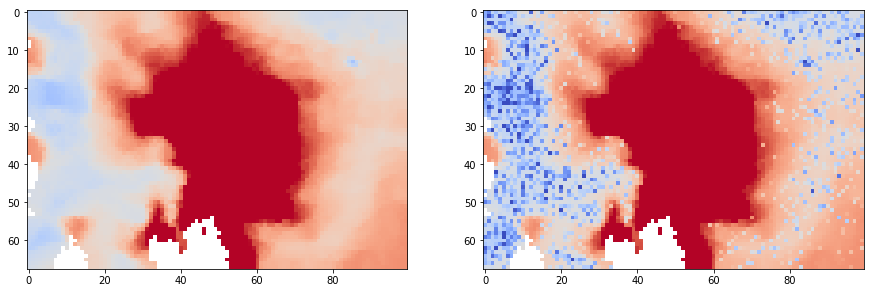

In [34]:
# Plot the original and the noisy image
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True,figsize=(15,15))
axs[0].imshow(np.flipud(Z_gauss), vmin=-0.5,vmax=0.5, cmap='coolwarm_r')
axs[1].imshow(np.flipud(Z_gauss_noisy), vmin=-0.5,vmax=0.5, cmap='coolwarm_r')

In [35]:
# Filter the image with a gaussian kernel of size 9 x 9
Z_filtered = gaussian_filter(Z_gauss_noisy, sigma=3, order=0)

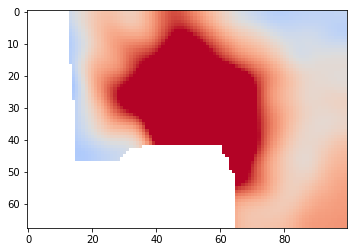

In [36]:
plt.imshow(np.flipud(Z_filtered), vmin=-0.5, vmax=0.5, cmap='coolwarm_r')

This does not look good what went wrong here? Well, it's because we have NaN's in the image and ndimage does not handle NaN's! Let's for now set them to zero and see what happens.

In [37]:
# Set NaN's to zero
Z_gauss_zero = Z_gauss.copy()
Z_gauss_zero[np.isnan(Z_gauss_zero)] = 0

In [38]:
# Apply the gaussian filter with sigma = 3, or N x M = 9 x 9.
Z_filter_gaussian = gaussian_filter(Z_gauss_zero, sigma=3, order=0)

In [39]:
# Apply the mask again
Z_filter_gaussian[Zm_ip == 0] = np.nan

Now let's plot the filtered and original image so we can compare them!

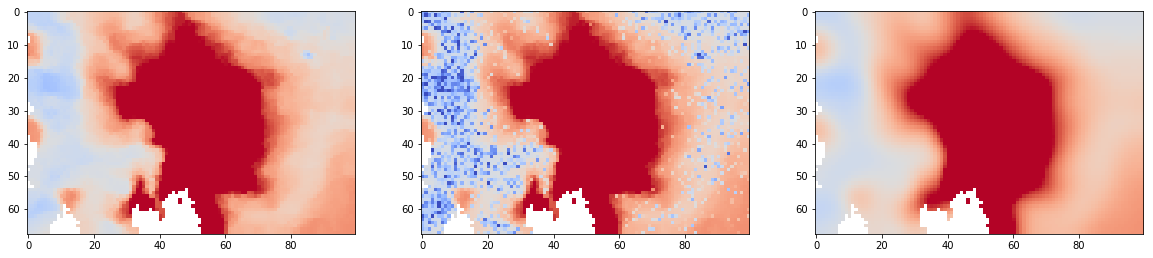

In [40]:
# Plot the data for us
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True,figsize=(20,20))
axs[0].imshow(np.flipud(Z_gauss), vmin=-0.5,vmax=0.5, cmap='coolwarm_r')
axs[1].imshow(np.flipud(Z_gauss_noisy), vmin=-0.5,vmax=0.5, cmap='coolwarm_r')
axs[2].imshow(np.flipud(Z_filter_gaussian), vmin=-0.5,vmax=0.5, cmap='coolwarm_r')

As expected the filtered image is smoother than the original and we can also see that the noise that we added is now reduced. You can play around with different values of sigma to vary the degree of smoothness you want in the image.  But, is this really a good way to filter our image? We did replace the NaN's in the image with zeros, which in contrast to NaN is a actual number! How can we get around this?

Well we can write our own filter that can handle NaN's! But, that seems difficult? Lucky for us there is what is called a generic filter function in ndimage where you can provide your own function. Let's use that instead for now.

In [41]:
from scipy.ndimage import generic_filter

Ok, let's try another filter this time! As we could see in the previous images is that using a gaussian filter we blur out many of the details in the image. So, let's use a median filter as this is good at removing noise but preserves more detail.

The generic filter takes as input a given function, in this case "np.nanmedian", and the size of the kernel we want use.

/Users/nilssonj/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


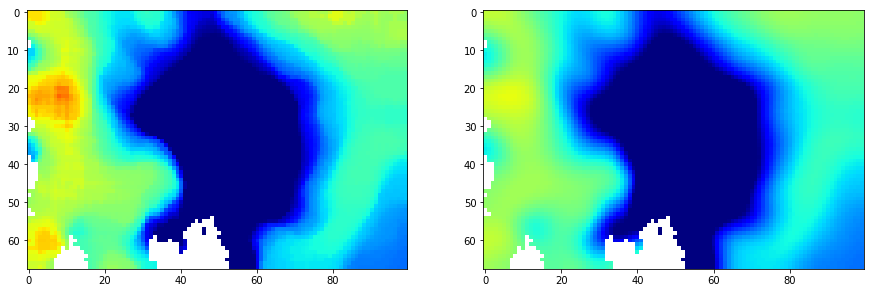

In [42]:
# We are using a median filter with the same size kernel as for the gaussian
Z_filter_median = generic_filter(Z_gauss_noisy.copy(), np.nanmedian, 9)

# Apply the mask again
Z_filter_median[Zm_ip == 0] = np.nan

# Plot the data
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(15,15))
axs[0].imshow(np.flipud(Z_filter_median), vmin=-0.5, vmax=0.5, cmap='jet')
axs[1].imshow(np.flipud(Z_filter_gaussian), vmin=-0.5, vmax=0.5, cmap='jet')

Let's try to commpute the volume change again on these grids to see if there is any difference?

In [43]:
print('Volume Change MED:', np.around(np.nansum(Z_filter_median) * 5e3 * 5e3 * 1e-9, 3), 'km3/yr')
print('Volume Change AVG:', np.around(np.nansum(Z_filter_gaussian) * 5e3 * 5e3 * 1e-9, 3), 'km3/yr')

('Volume Change MED:', -56.342, 'km3/yr')
('Volume Change AVG:', -59.164, 'km3/yr')


The difference is small, but we have more detail in the median filtered data, in the end it depends of what you are looking for.